In [146]:
# Load the "autoreload" extension
%load_ext autoreload

%autoreload 2

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math
import cv2
from data import voc_data_helpers
from data.voc_data_helpers import get_img_sets, extract_img_data
from minibatch import resize, get_rois, nms, get_ious, calc_iou, rpn_y_true
%matplotlib inline




import keras
from keras.layers import Input
from keras.layers.convolutional import Conv2D
from keras.models import Model, model_from_json
from keras.optimizers import SGD
from vgg16 import vgg16_rpn, vgg16_classifier, vgg16_base
from vgg16_dets import get_dets
from custom_layers import RoiResizeConv
from data import voc_data_helpers
from map_util import get_map
from loss_functions import cls_loss_rpn, bbreg_loss_rpn
import train_rpn

NUM_CLASSES_VOC = 20
DEFAULT_NUM_ITERATIONS = 10
DEFAULT_LEARN_RATE = 1e-3
DEFAULT_MOMENTUM = 0.9
VOC_PATH = 'a'

NUM_ROIS = 64

print(sys.version)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [147]:
class_mapping = voc_data_helpers.get_class_mapping(VOC_PATH)

In [148]:
base_model = vgg16_base(NUM_CLASSES_VOC + 1)
model_rpn = vgg16_rpn(base_model, NUM_CLASSES_VOC, include_conv = True)
model_rpn.load_weights('../models/rpn_weights_tmp.h5')

frcnn_json_file = open('../models/frcnn_module.json', 'r')
frcnn_loaded_model_json = frcnn_json_file.read()
frcnn_json_file.close()
model_frcnn = model_from_json(frcnn_loaded_model_json,
                                  custom_objects={'RoiResizeConv': RoiResizeConv})
model_frcnn.load_weights('../models/det_weights_step4.h5')

{'bboxes': [{'xmin': 213, 'difficult': True, 'ymin': 177, 'ymax': 232, 'xmax': 267, 'name': 'bird'}, {'xmin': 22, 'difficult': False, 'ymin': 220, 'ymax': 265, 'xmax': 87, 'name': 'bird'}], 'height': 375, 'width': 500}


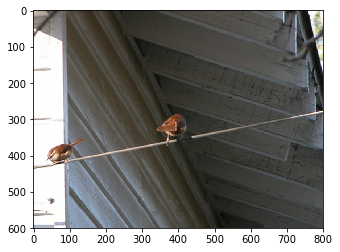

In [149]:
#img, img_metadata = voc_data_helpers.extract_img_data(VOC_PATH, '001915')
img, img_metadata = voc_data_helpers.extract_img_data(VOC_PATH, '001915')
print(img_metadata)
width, height = img_metadata['width'], img_metadata['height']
new_width, new_height = resize(width, height, 600)
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(cv_rgb, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
plt.imshow(resized_img)
batched_img = np.expand_dims(resized_img, axis=0)

In [150]:
dets = get_dets(model_rpn, model_frcnn, img, img_metadata, class_mapping)

[[  2.68410218e-08   1.98714212e-10   4.16798845e-10   1.06268860e-08
    1.75928938e-09   6.60806876e-09   8.12283227e-11   1.26538147e-09
    1.63795622e-09   2.71925438e-09   2.75453194e-09   3.21493836e-08
    2.69634232e-10   1.87216354e-10   4.95867560e-08   8.19357415e-10
    2.88816082e-10   2.07609013e-10   1.95172500e-09   1.41232970e-09
    9.99999881e-01]
 [  2.58831233e-06   1.86138660e-08   1.19836741e-07   2.41957764e-07
    2.48899994e-07   3.31492288e-07   3.47981697e-08   4.17982250e-07
    8.96380584e-07   2.88900623e-07   3.80379760e-07   3.90420428e-06
    6.60319230e-08   7.38665378e-08   1.64659855e-06   3.77367456e-07
    1.31521688e-07   1.03316864e-07   2.26619534e-07   3.78934928e-08
    9.99987841e-01]]


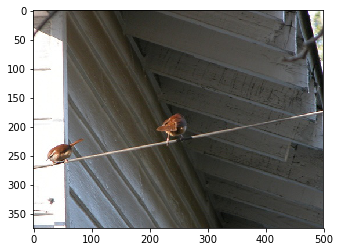

In [151]:
fig,ax = plt.subplots(1)
ax.imshow(cv_rgb)
for det in dets:
    x1, y1, x2, y2 = det['x1'], det['y1'], det['x2'], det['y2']
    class_name = det['cls_name']
    prob = det['prob']
    rect = patches.Rectangle((x1, y1), (x2 - x1), (y2 - y1), linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    label = "{}: {:.3f}".format(class_name, prob)
    ax.annotate(label, xy=(x1, y1), color='r', fontsize=20)

In [56]:
train_set, val_set, trainval_set = get_img_sets(VOC_PATH)

In [57]:
all_img_data = [extract_img_data(VOC_PATH, path) for path in val_set]

In [58]:
few_imgs = all_img_data[12:13]

In [59]:
get_map(model_rpn, model_frcnn, all_img_data, class_mapping, num_rois=64)

img 1: cumulative map 1.0
img 2: cumulative map 1.0
img 3: cumulative map 1.0
img 4: cumulative map 1.0


KeyboardInterrupt: 